In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

from copy import deepcopy
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad


from pathlib import Path
from gammapy.maps import MapAxis
from gammapy.data import DataStore
from gammapy.irf import Background2D, Background3D

from gammapy.catalog import SourceCatalogGammaCat, SourceCatalog3HWC, SourceCatalog4FGL
cat = SourceCatalogGammaCat("/raid/RAID1/VERITAS_Data/gammapy/gammapy-datasets/1.0.1/catalogs/gammacat/gammacat.fits.gz")
hawc = SourceCatalog3HWC("/raid/RAID1/VERITAS_Data/gammapy/gammapy-datasets/1.0.1/catalogs/3HWC.ecsv")

In [27]:
star_data = np.loadtxt("../Background/Hipparcos_MAG8_1997.dat", usecols=(0,1,2,3))
star_cat = Table( 
    {
        "ra" : star_data[:,0],
        "dec" : star_data[:,1],
        "id" : star_data[:,2],
        "mag" : star_data[:,3], 
    }
)
star_cat

ra,dec,id,mag
float64,float64,float64,float64
0.005024,38.859279,3.0,6.61
0.037336,46.939997,11.0,7.34
0.048422,-0.36045,14.0,7.25
0.053309,38.30405,19.0,6.53
0.066388,8.007234,21.0,7.55
0.074565,13.312234,23.0,7.57
0.079564,-44.290561,25.0,6.28
0.098082,2.675477,31.0,7.63
0.099585,26.918108,34.0,6.43


In [28]:
data_store = DataStore.from_dir("../Background/V6_2020_2021w/DL3-fullenc/")
# Select just the off data runs
obs_table = data_store.obs_table
observations = data_store.get_observations(obs_table["OBS_ID"],required_irf ="all-optional" )
print("Number of observations:", len(observations))

np.unique(obs_table["OBJECT"])

Number of observations: 1121


1ES 0414+009
1ES0033+595
1ES0229+200
1ES0502+675
1ES0647+250
1ES0806+524
1ES1011+496
1ES1028+511
1ES1215+303
1ES1218+304
1ES1727+502


/tmp/ipykernel_6280/1387530085.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


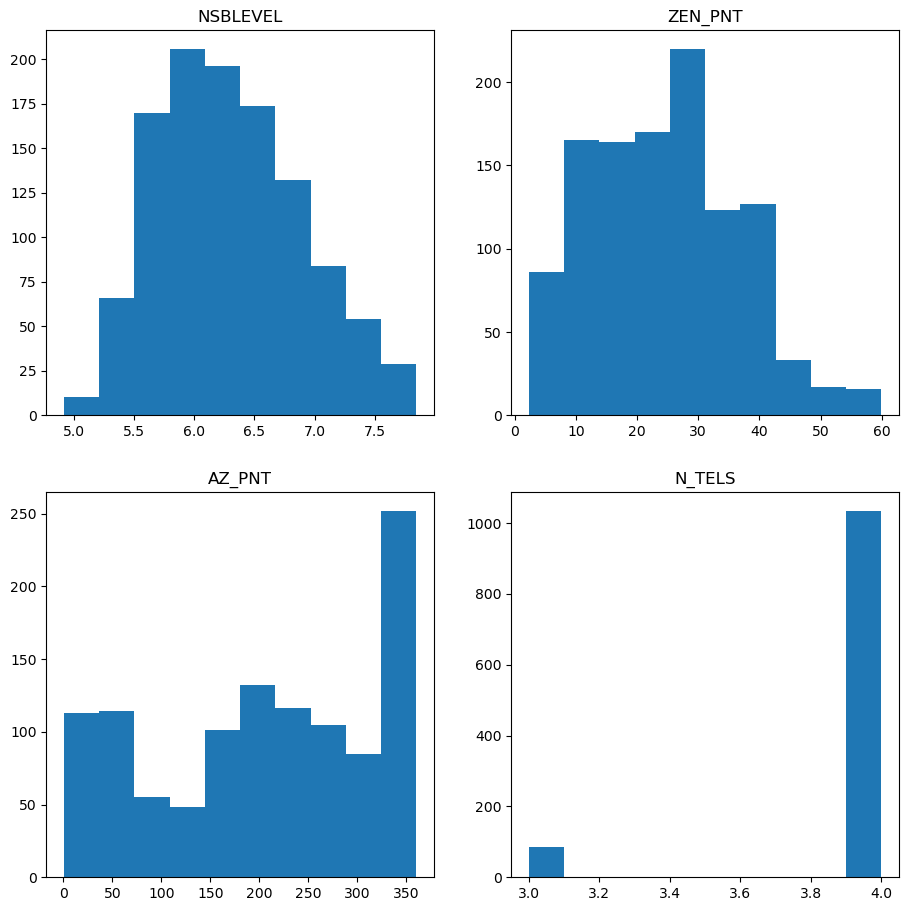

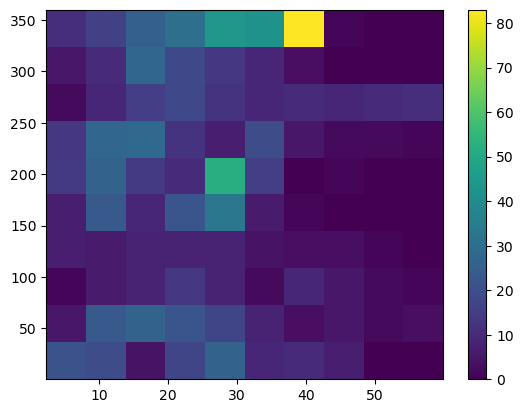

In [29]:
fig, axs = plt.subplots(2,2, figsize = (11,11))

of_interest = ["NSBLEVEL", "ZEN_PNT", "AZ_PNT", "N_TELS"]
for i, ax in enumerate(axs.ravel()):
    
    ax.hist(obs_table[of_interest[i]])
    ax.set_title(of_interest[i])
    
fig.show()
fig = plt.figure()
plt.hist2d(obs_table["ZEN_PNT"], obs_table["AZ_PNT"])
plt.colorbar()

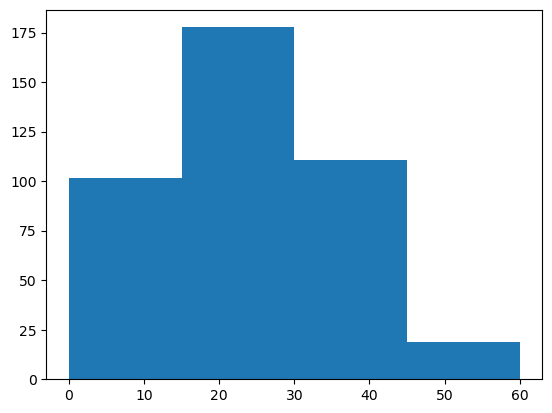

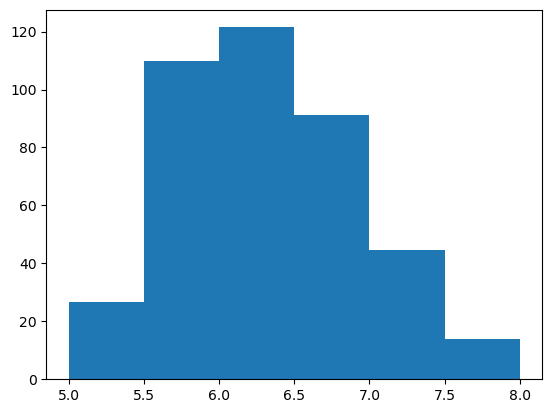

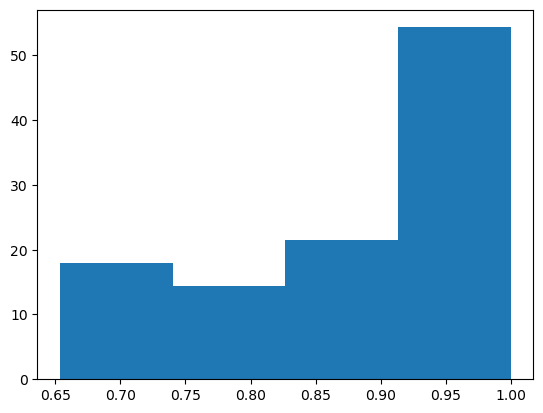

In [30]:
zen_bins = np.arange(0,61, 15)
noise_bins = np.arange(5.0, 8.5, 0.5)
az_bins = np.linspace(np.cos(359), np.cos(0),  5)

plt.hist(obs_table["ZEN_PNT"], weights= obs_table["LIVETIME"]/60/60, bins = zen_bins)
plt.show()

plt.hist(obs_table["NSBLEVEL"], weights= obs_table["LIVETIME"]/60/60, bins = noise_bins)
plt.show()

plt.hist(np.cos(obs_table["AZ_PNT"]), weights= obs_table["LIVETIME"]/60/60, bins = az_bins)
plt.show()


In [36]:
class BackgroundModelEstimator:
    """"""

    def __init__(self, energy, offset, excluded_sources = []):
        self.counts = self._make_bkg2d(energy, offset, unit="")
        self.exposure = self._make_bkg2d(energy, offset, unit="s MeV sr")
        self.excluded_sources = excluded_sources

    @staticmethod
    def _make_bkg2d(energy, offset, unit):
        shape = len(energy.center), len(offset.center)
        return Background2D(axes=[energy, offset], unit=unit)

    def run(self, observations):
        for obs in observations:
            self.fill_counts(obs)
#             self.fill_exposure(obs)

    def fill_counts(self, obs):
        events = obs.events
        

        run_mask = self.exclude_known_sources(obs)
        run_mask = self.exclude_bright_stars(obs, run_mask=run_mask)
        energy_bins = self.counts.axes["energy"].edges
        offset_bins = self.counts.axes["offset"].edges

        counts = np.histogram2d(
            x=events.energy.to("MeV")[run_mask],
            y=events.offset.to("deg")[run_mask],
            bins=(energy_bins, offset_bins),
        )[0]
        self.counts.data += counts

      
        # keep this all one function
        # All events
        counts_all = np.histogram(
            events.offset.to("deg"),
            bins = offset_bins
        )[0] + 1e-9
        # Only kept events
        counts_exc = np.histogram(
            events.offset[run_mask].to("deg"),
            bins = offset_bins
        )[0] + 1e-9

        axes = self.exposure.axes
        offset = axes["offset"].center
        time = obs.observation_time_duration
        exposure = 2 * np.pi * offset * time * axes.bin_volume()
        # Scale exposure by fraction of events accepted
        self.exposure.quantity += exposure * (counts_exc / counts_all)
#         print ((counts_exc / counts_all))
        
        
    # This could also be an exclusion file...
    def exclude_known_sources(self, obs, rad = 0.3, run_mask = None):
        
            
        if run_mask is None:
            run_mask = np.ones(len(obs.events.radec.ra), dtype = bool)
        
        # Excluding Gammacat sources
        # Sources nearby
        gamma_cat_reduced_mask = np.sqrt(
            (cat.table["ra"] - obs.fixed_pointing_info.radec.ra.deg)**2 +
            (cat.table["dec"] - obs.fixed_pointing_info.radec.dec.deg)**2
        ) < 2.5
        
        # Apply Exclusion region to FoV
        for source in cat.table[gamma_cat_reduced_mask]:
#             print (source["common_name"])
            # For extended source remove 3 times the extension?
            if source["morph_type"] in ["gauss", "shell"]:
                rad_ex = 3*source["morph_sigma"] * u.deg
                print (source["common_name"], rad_ex)
            else:
                rad_ex = 0.35 * u.deg
                
            run_mask *= (
                np.sqrt(
                    (obs.events.radec.ra - source["ra"]*u.deg)**2 + 
                    (obs.events.radec.dec - source["dec"]*u.deg)**2
                ) > rad_ex
            )

            
        # Excluding HAWC sources
        # Sources nearby
        hawc_reduced_mask = np.sqrt(
            (hawc.table["ra"] - obs.fixed_pointing_info.radec.ra.deg)**2 +
            (hawc.table["dec"] - obs.fixed_pointing_info.radec.dec.deg)**2
        ) < 2.5
        
        # Apply Exclusion region to FoV
        # ToDo: Extended sources
        for source in hawc.table[hawc_reduced_mask]:
            run_mask *= (
                np.sqrt(
                    (obs.events.radec.ra - source["ra"]*u.deg)**2 + 
                    (obs.events.radec.dec - source["dec"]*u.deg)**2
                ) > rad*u.deg
            )
        return run_mask
    
    # This could be sped up with a bright star file...
    def exclude_bright_stars(self, obs, rad = 0.3, mag = 8, run_mask = None):
        
        if run_mask is None:
            run_mask = np.ones(len(obs.events.radec.ra), dtype = bool)
        
        # Look for stars above a mag cut and within the FoV
        srcs_mask = np.sqrt(
            (star_cat["ra"] - obs.fixed_pointing_info.radec.ra.deg)**2 +
            (star_cat["dec"] - obs.fixed_pointing_info.radec.dec.deg)**2) < 2.
        srcs_mask &= star_cat["mag"] < mag 
            
        
        for src in star_cat[srcs_mask]:
            
            run_mask *= (
                np.sqrt(
                    (obs.events.radec.ra - src["ra"] * u.deg)**2 + 
                    (obs.events.radec.dec - src["dec"] * u.deg)**2
                ) > rad*u.deg
            )
        return run_mask
        
    @property
    def background_rate(self):
        rate = deepcopy(self.counts)
        rate.quantity /= self.exposure.quantity
        return rate

In [37]:
energy = MapAxis.from_energy_bounds(0.1, 100, 20, name="energy", unit="TeV")
offset = MapAxis.from_bounds(
    0, 2.5, nbin=10, interp="sqrt", unit="deg", name="offset"
)

mask = 0 <= obs_table["ZEN_PNT"]
mask &= obs_table["ZEN_PNT"] < 60
obs_ids = obs_table["OBS_ID"][mask]
observations = data_store.get_observations(obs_ids, required_irf="all-optional")

In [38]:
estimator = BackgroundModelEstimator(energy, offset)
estimator.run(observations)

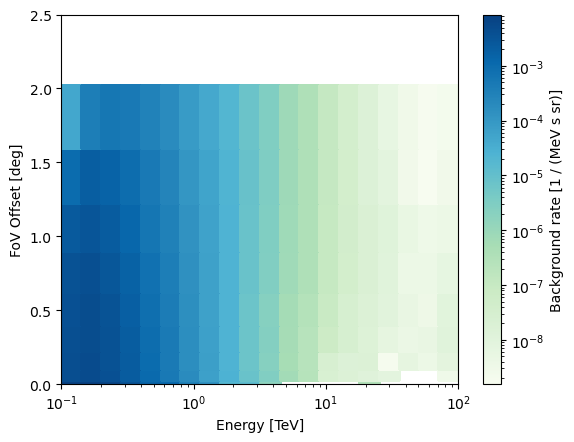

In [39]:
estimator.background_rate.plot()
plt.savefig("withoutCrab.png")

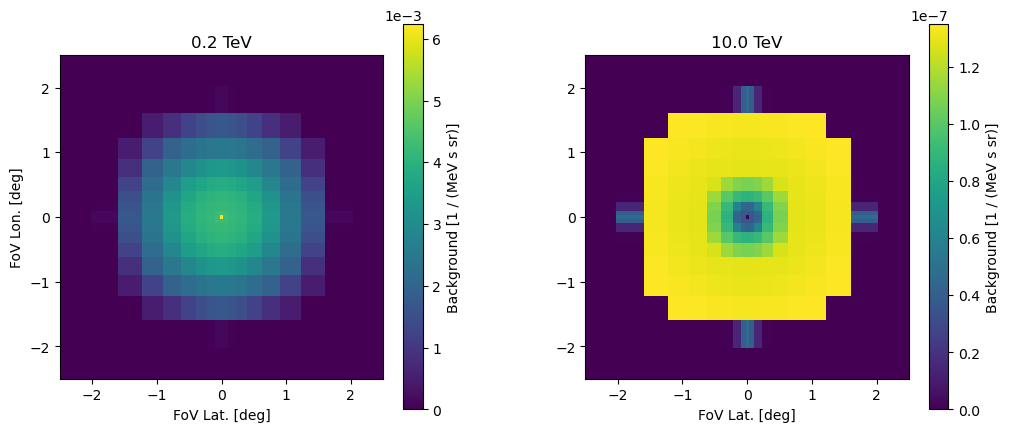

In [40]:
estimator.background_rate.plot_at_energy(energy = np.array([0.2, 10])*u.TeV)

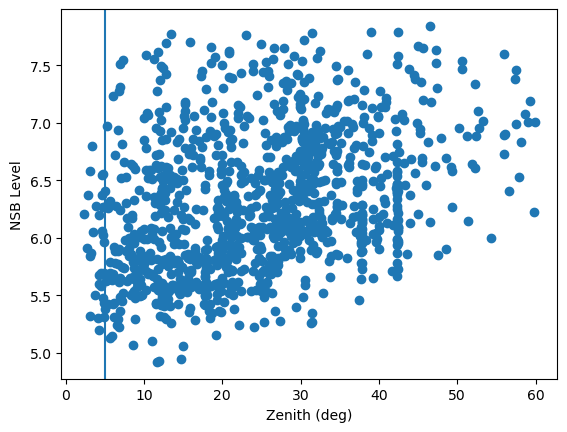

In [41]:
x = obs_table["ZEN_PNT"]
y = obs_table["NSBLEVEL"]
plt.plot(x, y, "o")
plt.xlabel("Zenith (deg)")
plt.ylabel("NSB Level");
plt.axvline(5)

In [88]:
for obs in observations[-1:]:
    print (obs)

Observation

	obs id            : 98536 
 	tstart            : 59324.47
	tstop             : 59324.48
	duration          : 901.00 s
	pointing (icrs)   : 300.0 deg, 64.6 deg

	deadtime fraction : 11.7%



In [79]:
crab = SkyCoord.from_name("crab")
(np.sqrt((obs.events.radec.ra - crab.ra)**2 + (obs.events.radec.dec - crab.dec)**2) < 0.3*u.deg )

array([False, False, False, ..., False, False, False])

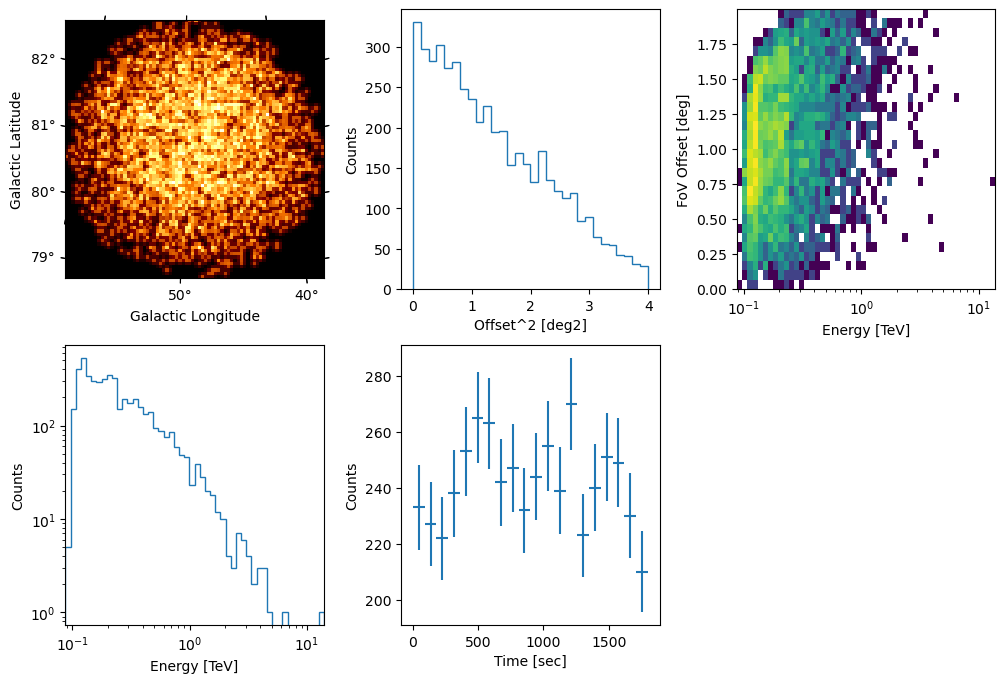

In [20]:
obs.events.peek()


In [15]:
len(obs.events.energy)

4833

In [16]:
obs.pointing_radec

<SkyCoord (ICRS): (ra, dec) in deg
    (202.94428664, 29.27688282)>

In [ ]:
estimator.

In [32]:
np.unique(cat.table["morph_type"])

gauss
none
point
shell


In [42]:
hawc.table[hawc.table["spec0_radius"] >0 ]

source_name,ra,dec,glon,glat,pos_err,search_radius,ts,spec0_dnde,spec0_dnde_errn,spec0_dnde_errp,spec0_dnde_sys_errn,spec0_dnde_sys_errp,spec0_index,spec0_index_errn,spec0_index_errp,spec0_index_sys_errn,spec0_index_sys_errp,spec0_radius
,deg,deg,deg,deg,deg,deg,,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,deg
str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3HWC J0621+382,95.317,38.206,175.444,10.966,0.301,0.5,28.0,8.95e-15,-1.51e-15,1.45e-15,-1.2e-15,2.57e-15,-2.41,-0.129,0.125,-0.014,0.081,0.500
3HWC J0634+067,98.657,6.730,205.029,-0.649,0.219,0.5,36.2,8.98e-15,-1.39e-15,1.34e-15,-1.23e-15,2.73e-15,-2.27,-0.102,0.095,-0.009,0.086,0.500
3HWC J1757-240,269.297,-24.092,5.486,0.252,0.480,1.0,28.6,7.2e-14,-1.13e-14,1.09e-14,-9.16e-15,1.76e-14,-2.80,-0.109,0.106,-0.033,0.067,1.000
3HWC J1951+266,297.905,26.610,63.228,-0.133,0.610,0.5,35.6,8.46e-15,-1.27e-15,1.18e-15,-1.3e-15,2.58e-15,-2.36,-0.129,0.125,-0.016,0.111,0.500
3HWC J2023+324,305.815,32.443,71.854,-2.770,0.732,1.0,30.7,1.38e-14,-2e-15,1.89e-15,-2.14e-15,3.15e-15,-2.70,-0.122,0.127,-0.026,0.060,1.000
3HWC J2043+443,310.888,44.301,83.744,1.098,0.241,0.5,28.6,9.67e-15,-2.19e-15,2.06e-15,-1.49e-15,3.92e-15,-2.33,-0.150,0.140,-0.015,0.112,0.500


In [46]:
cat.table[cat.table["common_name"] == "Boomerang PWN"]

source_id,common_name,gamma_names,fermi_names,other_names,where,classes,discoverer,seen_by,discovery_date,tevcat_id,tevcat2_id,tevcat_name,tgevcat_id,tgevcat_name,reference_id,significance,livetime,ra,dec,glon,glat,pos_ra,pos_dec,pos_glon,pos_glat,pos_err,morph_type,morph_sigma,morph_sigma_err,morph_sigma2,morph_sigma2_err,morph_pa,morph_pa_err,morph_pa_frame,spec_type,spec_pl_norm,spec_pl_norm_err,spec_pl_norm_err_sys,spec_pl_index,spec_pl_index_err,spec_pl_index_err_sys,spec_pl_e_ref,spec_pl2_flux,spec_pl2_flux_err,spec_pl2_flux_err_sys,spec_pl2_index,spec_pl2_index_err,spec_pl2_index_err_sys,spec_pl2_e_min,spec_pl2_e_max,spec_ecpl_norm,spec_ecpl_norm_err,spec_ecpl_norm_err_sys,spec_ecpl_index,spec_ecpl_index_err,spec_ecpl_index_err_sys,spec_ecpl_e_cut,spec_ecpl_e_cut_err,spec_ecpl_e_cut_err_sys,spec_ecpl_e_ref,spec_erange_min,spec_erange_max,spec_theta,spec_dnde_1TeV,spec_dnde_1TeV_err,spec_flux_1TeV,spec_flux_1TeV_err,spec_flux_1TeV_crab,spec_flux_1TeV_crab_err,spec_eflux_1TeV_10TeV,spec_eflux_1TeV_10TeV_err,sed_reference_id,sed_n_points,sed_n_ul,sed_e_ref,sed_e_min,sed_e_max,sed_dnde,sed_dnde_err,sed_dnde_errp,sed_dnde_errn,sed_dnde_ul
,,,,,,,,,,,,,,,,,h,deg,deg,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,deg,deg,deg,,,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,TeV,1 / (s cm2),1 / (s cm2),1 / (s cm2),,,,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,TeV,TeV,TeV,TeV,TeV,TeV,deg,1 / (TeV s cm2),1 / (TeV s cm2),1 / (s cm2),1 / (s cm2),,,erg / (s cm2),erg / (s cm2),,,,TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2)
int32,bytes21,bytes76,bytes72,bytes73,bytes4,bytes11,bytes8,bytes35,bytes7,int64,bytes6,bytes14,int64,bytes14,bytes19,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes5,float32,float32,float32,float32,float32,float32,bytes8,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes19,int32,int32,float32[40],float32[40],float32[40],float32[40],float32[40],float32[40],float32[40],float32[40]
150,Boomerang PWN,"MGRO C4,MGRO J2228+61,0FGL J2229.0+6114",--,"SNR G106.6+2.9,PSR J2229+6114",gal,"pwn,snr",milagro,milagro,2009-04,182,qsRoN6,TeV J2228+611,150,TeV J2228+6110,--,--,--,337.25,61.2,106.619774,2.923463,--,--,--,--,--,none,--,--,--,--,--,--,--,none,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0,0,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --


In [48]:
hdul = estimator.background_rate.to_hdulist()

In [49]:
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BACKGROUND    1 BinTableHDU     36   1R x 5C   ['20D', '20D', '10D', '10D', '200D']   


In [50]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2080 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
HDUCLASS= 'GADF    '                                                            
HDUDOC  = 'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'    
HDUVERS = '0.2     '                                                            
HDUCLAS1= 'RESPONSE'                                                            
HDUCLAS2= 'BKG     '        

In [66]:
zen_range = np.arange(0,66, 10)
nsb_range = np.arange(5,8.1, 1)
az_range = np.linspace(0, 360, 5)
# plt.hist(obs_table["ZEN_PNT"], weights= obs_table["LIVETIME"]/60/60, bins = zen_bins)
# plt.show()

# plt.hist(obs_table["NSBLEVEL"], weights= obs_table["LIVETIME"]/60/60, bins = nsb_range)
# plt.show()

# plt.hist(np.cos(obs_table["AZ_PNT"]), weights= obs_table["LIVETIME"]/60/60, bins = az_bins)
# plt.show()


for i in range(len(zen_range) -1):
    
    zen_mask = (obs_table["ZEN_PNT"] >= zen_range[i]) & (obs_table["ZEN_PNT"] < zen_range[i+1])
    zen_cen = np.mean(zen_range[i:i+2])
#     print (zen_cen)
    
    for j in range(len(nsb_range) -1):
        nsb_mask = (obs_table["NSBLEVEL"] >= nsb_range[j]) & (obs_table["NSBLEVEL"] < nsb_range[j+1])
        nsb_cen = np.mean(nsb_range[j:j+2])
        
        for k in range(len(az_range) -1):
            az_mask = (obs_table["AZ_PNT"] >= az_range[k]) & (obs_table["AZ_PNT"] < az_range[k+1])
            az_cen = np.mean(az_range[k:k+2])
        
            nhours = np.sum(obs_table["LIVETIME"][zen_mask & nsb_mask & az_mask]) / 60 / 60
            print (f"{zen_cen:0.0f} ({90 - zen_cen:0.0f})\t{nsb_cen:0.1f}\t{az_cen:0.1f} : {nhours:0.2f} hours")


5 (85)	5.5	45.0 : 8.04 hours
5 (85)	5.5	135.0 : 6.18 hours
5 (85)	5.5	225.0 : 10.45 hours
5 (85)	5.5	315.0 : 3.48 hours
5 (85)	6.5	45.0 : 5.59 hours
5 (85)	6.5	135.0 : 1.65 hours
5 (85)	6.5	225.0 : 3.92 hours
5 (85)	6.5	315.0 : 2.73 hours
5 (85)	7.5	45.0 : 0.00 hours
5 (85)	7.5	135.0 : 0.00 hours
5 (85)	7.5	225.0 : 1.71 hours
5 (85)	7.5	315.0 : 0.44 hours
15 (75)	5.5	45.0 : 16.75 hours
15 (75)	5.5	135.0 : 10.17 hours
15 (75)	5.5	225.0 : 10.29 hours
15 (75)	5.5	315.0 : 17.49 hours
15 (75)	6.5	45.0 : 4.95 hours
15 (75)	6.5	135.0 : 9.36 hours
15 (75)	6.5	225.0 : 16.32 hours
15 (75)	6.5	315.0 : 7.84 hours
15 (75)	7.5	45.0 : 0.26 hours
15 (75)	7.5	135.0 : 1.64 hours
15 (75)	7.5	225.0 : 8.17 hours
15 (75)	7.5	315.0 : 1.74 hours
25 (65)	5.5	45.0 : 14.00 hours
25 (65)	5.5	135.0 : 10.18 hours
25 (65)	5.5	225.0 : 5.75 hours
25 (65)	5.5	315.0 : 8.80 hours
25 (65)	6.5	45.0 : 9.56 hours
25 (65)	6.5	135.0 : 18.39 hours
25 (65)	6.5	225.0 : 20.85 hours
25 (65)	6.5	315.0 : 24.04 hours
25 (65)	7.5	45.0 

In [72]:
for i in range(len(zen_range) -1):
    
    zen_mask = (obs_table["ZEN_PNT"] >= zen_range[i]) & (obs_table["ZEN_PNT"] < zen_range[i+1])
    zen_cen = np.mean(zen_range[i:i+2])
#     print (zen_cen)
    
    for j in range(len(nsb_range) -1):
        nsb_mask = (obs_table["NSBLEVEL"] >= nsb_range[j]) & (obs_table["NSBLEVEL"] < nsb_range[j+1])
        nsb_cen = np.mean(nsb_range[j:j+2])
        
        for k in range(len(az_range) -1):
            az_mask = (obs_table["AZ_PNT"] >= az_range[k]) & (obs_table["AZ_PNT"] < az_range[k+1])
            az_cen = np.mean(az_range[k:k+2])
        
            nhours = np.sum(obs_table["LIVETIME"][zen_mask & nsb_mask & az_mask]) / 60 / 60
            print (f"{zen_cen:0.0f} ({90 - zen_cen:0.0f})\t{nsb_cen:0.1f}\t{az_cen:0.1f} : {nhours:0.2f} hours")
            
            
            energy = MapAxis.from_energy_bounds(0.1, 100, 20, name="energy", unit="TeV")
            offset = MapAxis.from_bounds(
                0, 2.5, nbin=10, interp="sqrt", unit="deg", name="offset"
            )


            obs_ids = obs_table["OBS_ID"][zen_mask & nsb_mask & az_mask]
            if len(obs_ids) < 1:
                continue
    
            observations = data_store.get_observations(obs_ids, required_irf="all-optional")
            
            
            estimator = BackgroundModelEstimator(energy, offset)
            estimator.run(observations)
            fig = plt.figure()
            ax = fig.subplots()
            estimator.background_rate.plot(ax)
            plt.savefig(f"background_{zen_range[i]:0.0f}-{zen_range[i+1]:0.0f}_ze_{nsb_range[j]:0.1f}-{nsb_range[j+1]:0.1f}_nsb_{az_range[k]:0.1f}-{az_range[k+1]:0.1f}_az.png")
            plt.close(fig)
            hdul = estimator.background_rate.to_hdulist()
            hdul[1].header["ZEMIN"] = zen_range[i]
            hdul[1].header["ZEMAX"] = zen_range[i+1]
            hdul[1].header["NSBMIN"] = nsb_range[j]
            hdul[1].header["NSBMAX"] = nsb_range[j+1]
            hdul[1].header["AZMIN"] = az_range[k]
            hdul[1].header["AZMAX"] = az_range[k+1]
            hdul[1].header["HOURS"] = nhours
            
            hdul.writeto(f"background_{zen_range[i]:0.0f}-{zen_range[i+1]:0.0f}_ze_{nsb_range[j]:0.1f}-{nsb_range[j+1]:0.1f}_nsb_{az_range[k]:0.1f}-{az_range[k+1]:0.1f}_az.fits", overwrite=True)
            

5 (85)	5.5	45.0 : 8.04 hours
5 (85)	5.5	135.0 : 6.18 hours
5 (85)	5.5	225.0 : 10.45 hours
5 (85)	5.5	315.0 : 3.48 hours
5 (85)	6.5	45.0 : 5.59 hours
5 (85)	6.5	135.0 : 1.65 hours
5 (85)	6.5	225.0 : 3.92 hours
5 (85)	6.5	315.0 : 2.73 hours
5 (85)	7.5	45.0 : 0.00 hours
5 (85)	7.5	135.0 : 0.00 hours
5 (85)	7.5	225.0 : 1.71 hours
5 (85)	7.5	315.0 : 0.44 hours
15 (75)	5.5	45.0 : 16.75 hours
15 (75)	5.5	135.0 : 10.17 hours
15 (75)	5.5	225.0 : 10.29 hours
15 (75)	5.5	315.0 : 17.49 hours
15 (75)	6.5	45.0 : 4.95 hours
15 (75)	6.5	135.0 : 9.36 hours
15 (75)	6.5	225.0 : 16.32 hours
15 (75)	6.5	315.0 : 7.84 hours
15 (75)	7.5	45.0 : 0.26 hours
15 (75)	7.5	135.0 : 1.64 hours
15 (75)	7.5	225.0 : 8.17 hours
15 (75)	7.5	315.0 : 1.74 hours
25 (65)	5.5	45.0 : 14.00 hours
25 (65)	5.5	135.0 : 10.18 hours
25 (65)	5.5	225.0 : 5.75 hours
25 (65)	5.5	315.0 : 8.80 hours
25 (65)	6.5	45.0 : 9.56 hours
25 (65)	6.5	135.0 : 18.39 hours
25 (65)	6.5	225.0 : 20.85 hours
25 (65)	6.5	315.0 : 24.04 hours
25 (65)	7.5	45.0 

<Axes: xlabel='Energy [TeV]', ylabel='Background rate [1 / (MeV s sr)]'>

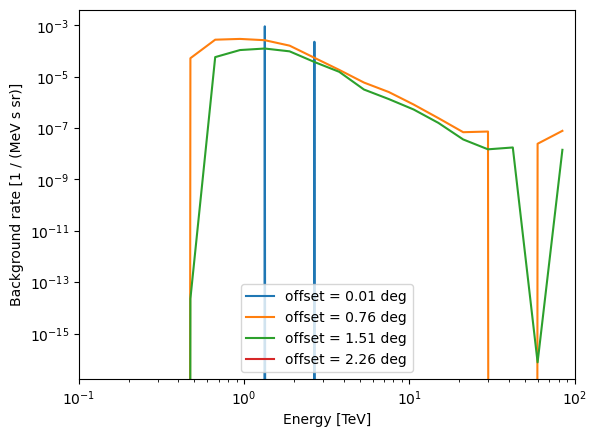

In [75]:
estimator.background_rate.plot_energy_dependence()